In [3]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

# Figure 2A: Tumor UMAP

In [4]:
tumor = readRDS('allcells/tumor/seurat_obj/integrated_tumor_broadanno_Oct2023.rds')

Clean up labels for use in figure

In [5]:
# Define mapping
newIDs <- c(
  "890 EGFR-high" = "NCAM1-high",
  "909 PDGFRA-high" = "PDGFRA-high",
  "ccRCC balanced" = "ccRCC balanced",
  "Papillary RADIL-high" = "RADIL-high",
  "Contaminant - Immune-like tumor cell" = "Excluded",
  "SRR19987214 CADM1-high" = "CADM1-high",
  "Undetermined" = "Excluded",
  "XpTranslocation TRIM63-high" = "TRIM63-high"
)

# Create a data frame of mapping
df <- tibble::tibble(
  tumor_annotation = names(newIDs),
  annotation = newIDs
)

# Update metadata with new annotations
metadata <- tumor@meta.data %>%
  rownames_to_column("barcode") %>%
  dplyr::inner_join(df, by = c("tumor_annotation" = "tumor_annotation")) %>%
  dplyr::select(barcode, annotation) %>%
  column_to_rownames("barcode")

# Add updated metadata back to the Seurat object
tumor <- Seurat::AddMetaData(tumor, metadata = metadata)

Define tumor annotation order so that we can assign a color to a specific annotation

In [6]:
# order
levels = unique(tumor$annotation)[-2]
tumor$annotation <- factor(tumor$annotation, levels = c('Excluded',levels))

#colors
excluded = alpha(c('#E8E9EB'), 0.3)
sample_cols <- colorRampPalette(brewer.pal(8, "Set2"))(8)
p1 = sample_cols[3:7]
sample_cols = c(p1, sample_cols[2])

Plot UMAP

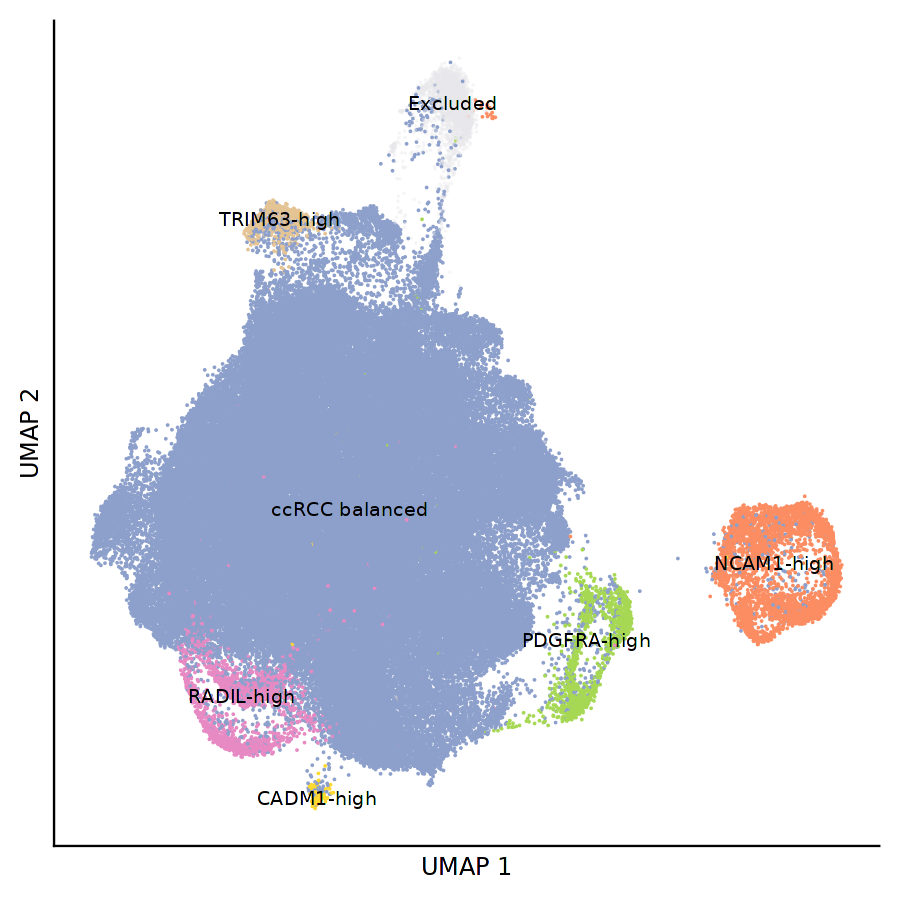

In [30]:
options(repr.plot.width=7.5, repr.plot.height=7.5)
DimPlot(tumor, label = TRUE, group.by = 'annotation', cols = c(excluded,sample_cols), raster = FALSE, reduction = 'harmony_UMAP', shuffle = TRUE) + theme(plot.title = element_blank(), legend.text = element_text(size = 14), axis.text = element_blank(), axis.ticks = element_blank()) +
xlab('UMAP 1') + ylab('UMAP 2') + NoLegend()

Number of non-excluded cells and unique patient IDs

In [38]:
# Cells
cells = dim(tumor@meta.data %>% filter(annotation != 'Excluded'))[1]
print(glue('The number of non-exluded tumor cells is {cells}.'))

# Patients
num_pts = length(unique((tumor@meta.data %>% filter(annotation != 'Excluded'))$participant))
print(glue('The number of patients with non-excluded tumor cells is {num_pts}.'))

The number of non-exluded tumor cells is 111151.
The number of patients with non-excluded tumor cells is 58.


# Figure 2B: Tumor gene activity heatmap

Calculate differential gene accessibility on non-excluded annotations. Results in Supp Table 2, sheet A. 

In [10]:
tumor_filtered = subset(tumor, subset = tumor_annotation %in% setdiff(unique(tumor$tumor_annotation),c('Undetermined', 'Contaminant - Immune-like tumor cell')))

DefaultAssay(tumor_filtered) = 'RNA'
Idents(tumor_filtered) = 'tumor_annotation'
differential_geneactivity = FindAllMarkers(tumor_filtered, min.pct = 0.2, test.use = 'LR', latent.vars = 'nCount_ATAC', max.cells.per.ident = 1000, logfc.threshold = 0.1, only.pos = TRUE)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony_umap_ to harmonyumap_"


Map annotations to what's used in the figures. 

In [8]:
# Define mapping
newIDs <- c(
  "890 EGFR-high" = "NCAM1-high",
  "909 PDGFRA-high" = "PDGFRA-high",
  "ccRCC balanced" = "ccRCC balanced",
  "Papillary RADIL-high" = "RADIL-high",
  "SRR19987214 CADM1-high" = "CADM1-high",
  "XpTranslocation TRIM63-high" = "TRIM63-high"
)

# Map
differential_geneactivity <- differential_geneactivity %>%
  dplyr::left_join(
    tibble::tibble(cluster = names(newIDs), new_cluster = newIDs),
    by = "cluster"
  ) %>%
  dplyr::mutate(
    cluster = factor(new_cluster, levels = levels)
  ) %>%
  dplyr::select(-new_cluster)

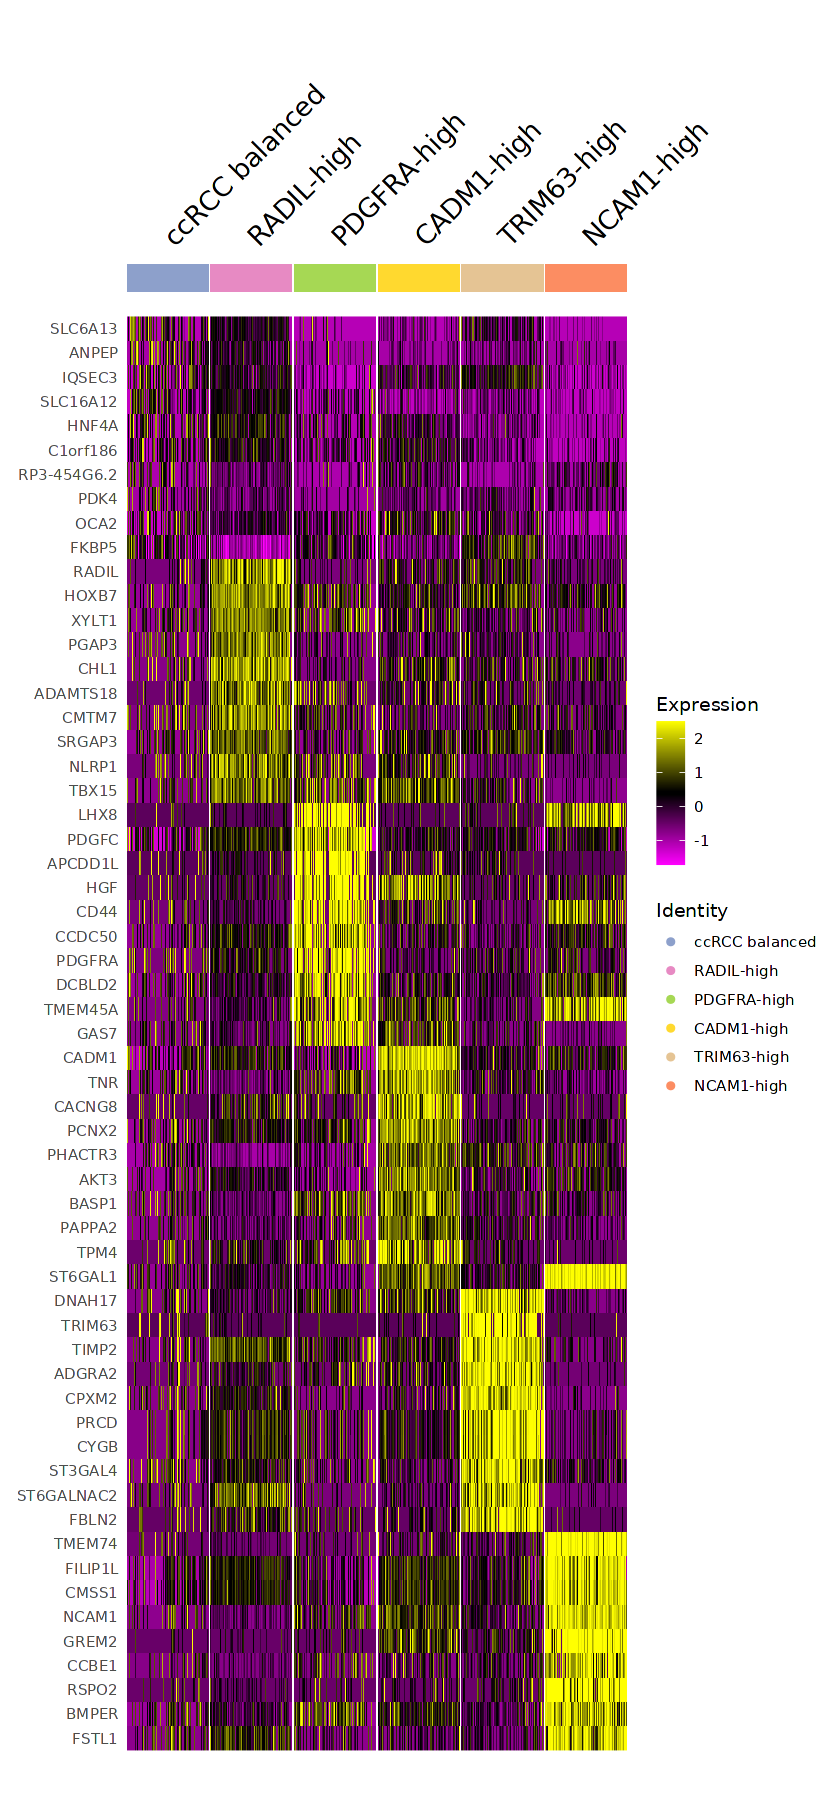

In [55]:
# Set order of annotation for plotting
tumor_filtered$annotation = factor(tumor_filtered$annotation, levels = levels)
Idents(tumor_filtered) = 'annotation'

# Select top 10 differentially accessible genes per annotation
differential_geneactivity %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10

# Scale gene activity assay for plotting
tumor_filtered = ScaleData(tumor_filtered, assay = 'RNA')

# Plot heatmap
options(repr.plot.width=7, repr.plot.height=15)
DoHeatmap(subset(tumor_cleaned, downsample = 100), features = top10$gene, group.colors = sample_cols)

# Figure 2C: ccRCC balanced UMAP

In [10]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')

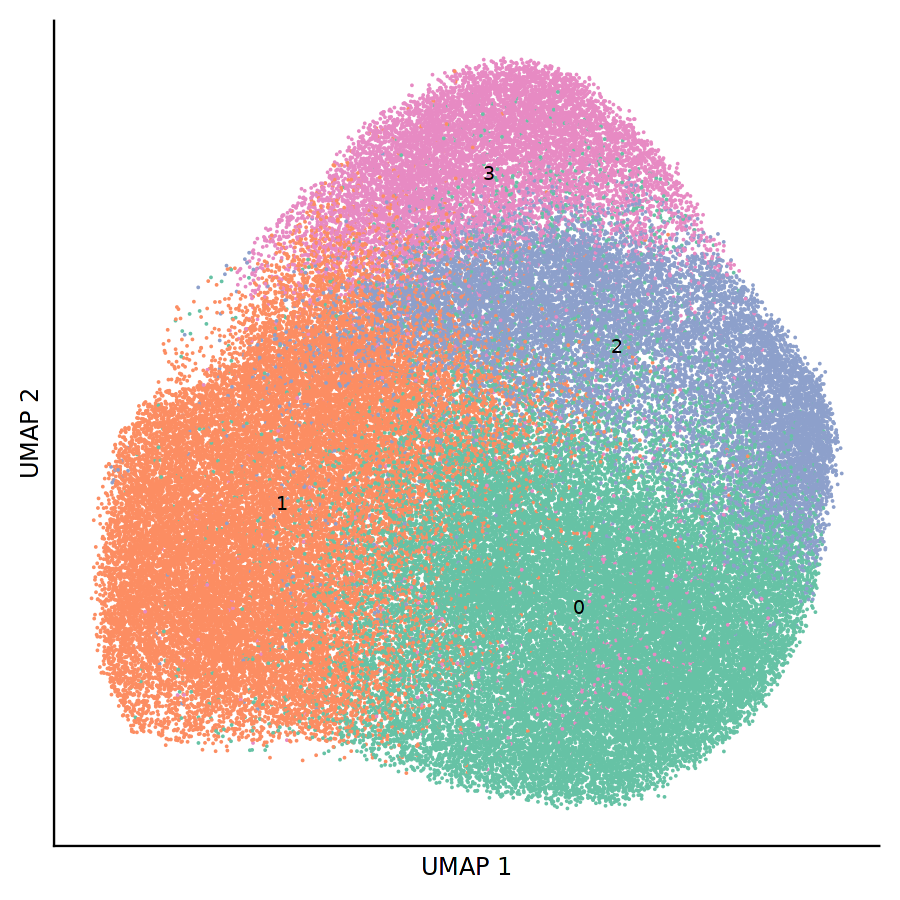

In [13]:
tumor_cols <- colorRampPalette(brewer.pal(4, "Set2"))(4)

options(repr.plot.width=7.5, repr.plot.height=7.5)
DimPlot(ccrcc, label = TRUE, cols = tumor_cols, raster = FALSE, reduction = 'harmony_UMAP', shuffle = TRUE) + theme(plot.title = element_blank(), legend.text = element_text(size = 14), axis.text = element_blank(), axis.ticks = element_blank()) +
xlab('UMAP 1') + ylab('UMAP 2') + NoLegend()

Number of cells and unique patient IDs

In [11]:
# Cells
cells = dim(ccrcc@meta.data)[1]
print(glue('The number of ccRCC tumor cells is {cells}.'))

# Patients
num_pts = length(unique((ccrcc@meta.data)$participant))
print(glue('The number of patients with ccRCC tumor cells is {num_pts}.'))

The number of ccRCC tumor cells is 88739.
The number of patients with ccRCC tumor cells is 56.


# Figure 2D: ccRCC peak heatmap

For each cluster (`cluster_id`), we ran the below script. Then we concatenated the output from each cluster into one file. These results can be found in Supp table 2, sheet B. 

```
#For each cluster - one vs all
DefaultAssay(ccrcc) = 'ATAC'
clusters = c(0,1,2,3)
group1 = row.names(ccrcc@meta.data %>% filter(seurat_clusters == cluster_id))
group2 = row.names(ccrcc@meta.data %>% filter(seurat_clusters %in% setdiff(clusters, cluster_id)))
markers = FindMarkers(ccrcc, `ident.1` = group1, `ident.2` = group2, min.pct = 0.1, test.use = 'LR', latent.vars = 'nCount_ATAC', max.cells.per.ident = 1000, logfc.threshold = 0.1, only.pos = TRUE)
if (dim(markers)[1] != 0) {
    markers$cluster = cluster_id
    markers$gene = row.names(markers)
}
write.table(markers, file = output_file, sep = "\t", quote = FALSE, row.names = TRUE)```
```

In [14]:
da_peaks = read.table("allcells/tumor/findmarkers/ccrcc_balanced_peaks_nov2023.txt", row.names = NULL)
sigpeaks = da_peaks %>% filter(p_val_adj < 0.05)

Create an average accessibility object

In [16]:
DefaultAssay(ccrcc) = 'ATAC'
sigpeak_obj = subset(ccrcc, features = sigpeaks$gene)
sigpeak_obj$biopsy_cluster = paste0(sigpeak_obj$biopsy, '_', sigpeak_obj$seurat_clusters)
Idents(sigpeak_obj) = 'biopsy_cluster'
DefaultAssay(sigpeak_obj) = 'ATAC'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Warning message in rownames(x = object) == rownames(x = new.data):
"longer object length is not a multiple of shorter object length"
Warning message in SetAssayData.ChromatinAssay(object = new.assay, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."
Centering and scaling data matrix



Add in desired metadata for the heatmap

In [18]:
# Extract biopsy ID and cluster ID from row names and add them to metadata
sigpeak_obj@meta.data <- sigpeak_obj@meta.data %>%
  dplyr::mutate(
    biopsy = substr(row.names(.), 1, nchar(row.names(.)) - 2),  # Extract biopsy ID
    seurat_clusters = substr(row.names(.), nchar(row.names(.)), nchar(row.names(.))) %>% as.factor()  # Extract cluster ID and convert to factor
  )

# Extract cohort information from `ccrcc` metadata
cohort_anno <- ccrcc@meta.data %>%
  dplyr::select(biopsy, cohort) %>%
  dplyr::distinct()

# Merge cohort information with `sigpeak_obj` metadata
updated_meta <- sigpeak_obj@meta.data %>%
  dplyr::mutate(barcodes = row.names(.)) %>%  # Add barcodes as a column
  dplyr::left_join(cohort_anno, by = "biopsy") %>%  # Join with cohort annotation
  tibble::column_to_rownames("barcodes") %>%  # Restore row names
  dplyr::select(cohort)  # Select only the cohort column

# Add updated metadata to `sigpeak_obj`
sigpeak_obj <- AddMetaData(sigpeak_obj, metadata = updated_meta)

Plot

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"


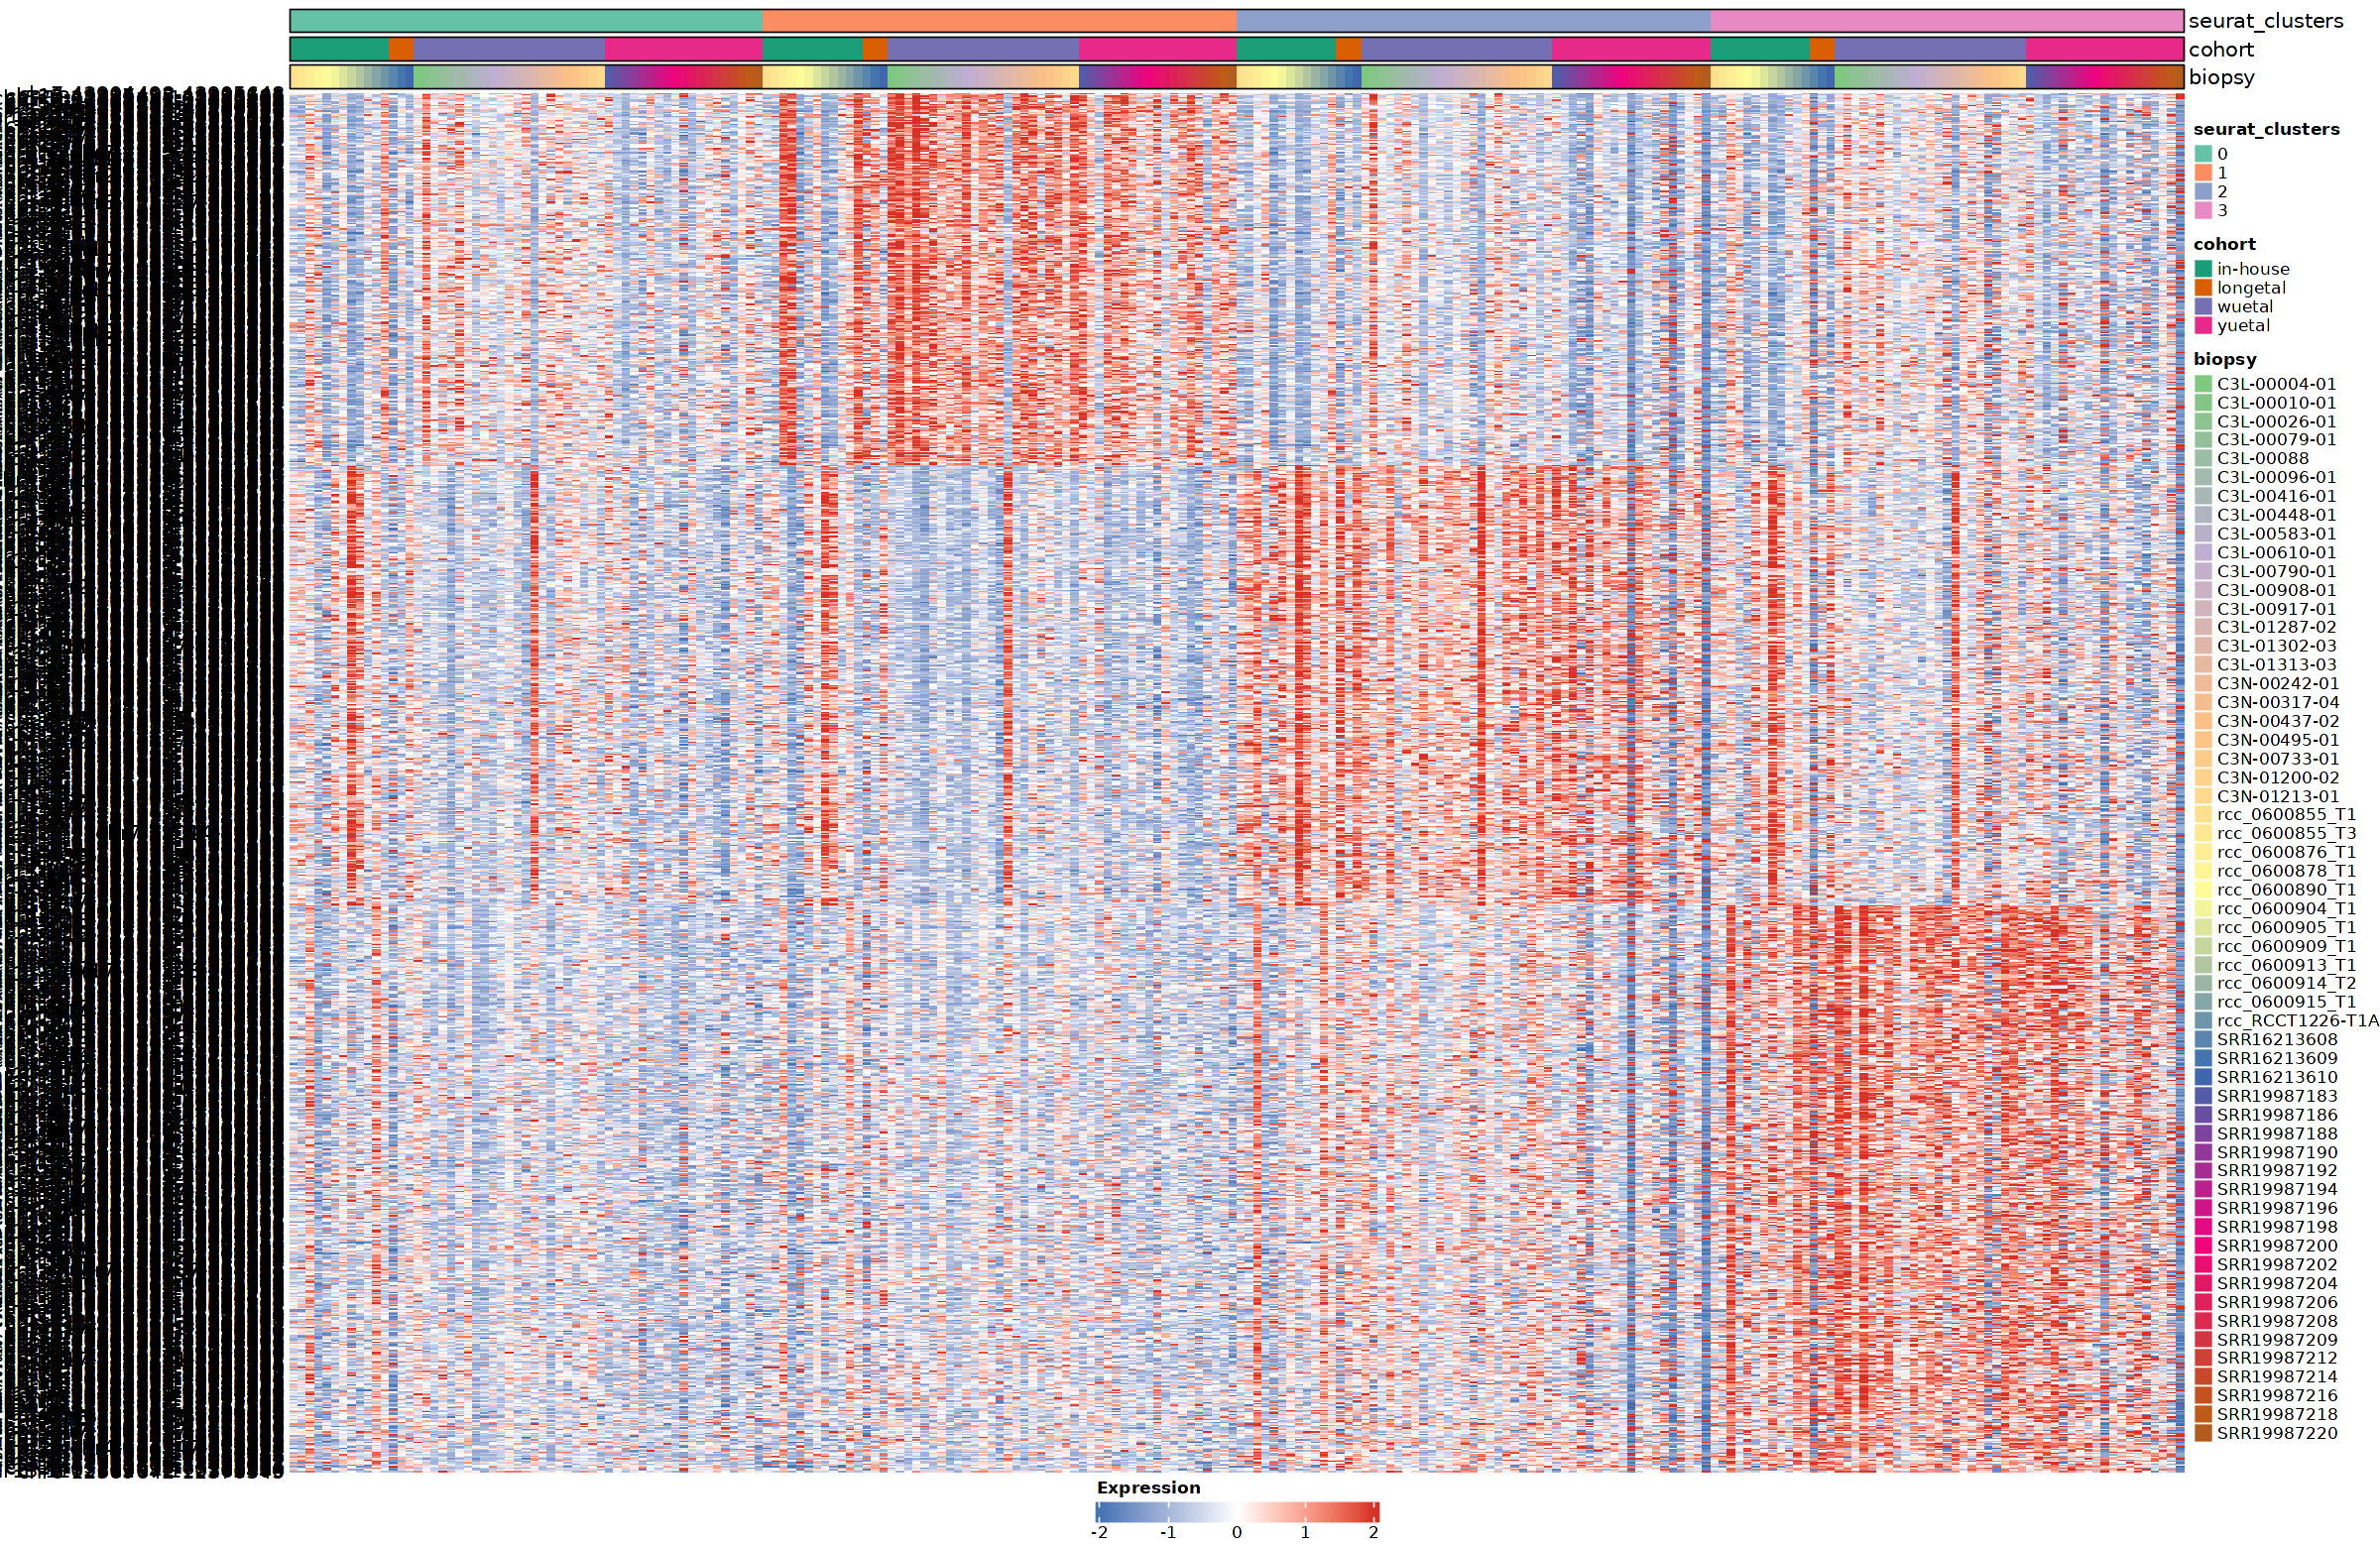

In [20]:
tumor_cols <- colorRampPalette(brewer.pal(4, "Set2"))(4)
cohort_cols <- colorRampPalette(brewer.pal(4, "Dark2"))(4)
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)

options(repr.plot.width=20, repr.plot.height=13)
plot_heatmap(sigpeak_obj, markers = sigpeaks$gene,anno_var = c('seurat_clusters','cohort','biopsy'),
             anno_colors = list(tumor_cols,cohort_cols, sample_cols), sort_var = c('seurat_clusters','cohort','biopsy'))

# Figure 2E: GREAT pathway results for ccRCC peak sets


GREAT pathway enrichment results in Supp table 2, sheet C. 

## C1

In [22]:
# Read in GREAT results
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))

great_results = read.table('allcells/tumor/great/greatExportAll_c1.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
keep = c('GO Biological Process','Disease Ontology', 'MSigDB Pathway')
great_results$Ontology2 = great_results$Ontology
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 

In [25]:
# Subset to terms we want to plot for C1
terms = c('transmembrane transport', 'Genes involved in Transport of glucose and other sugars, bile salts and organic acids, metal ions and amine compounds')
selected = great_results %>% filter(Desc %in% terms)
selected$Desc <- str_wrap(selected$Desc, width = 40)
selected <- selected %>%
  mutate(neg_log10_BinomFdrQ = -log10(BinomFdrQ))

In [24]:
min(selected$GeneFoldEnrich)
max(selected$GeneFoldEnrich)

[1] 2.303926

[1] 5.015452

Color scale limits reflect min and max `GeneFoldEnrich` observed among selected terms for C1, C2, and C3. 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


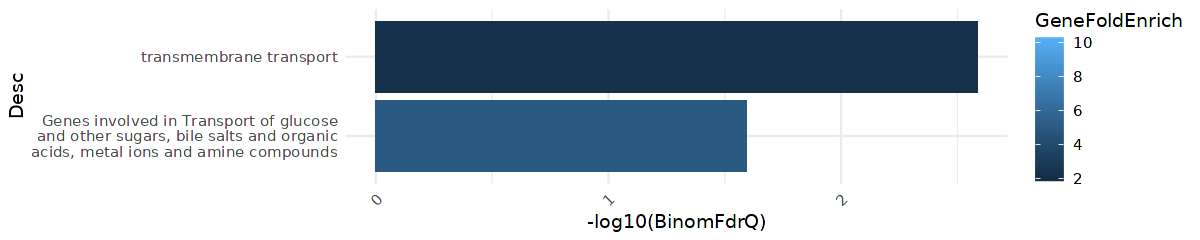

In [26]:
options(repr.plot.width=10, repr.plot.height=2)
ggplot(data = selected, aes(x = Desc, y = neg_log10_BinomFdrQ, fill = GeneFoldEnrich)) +
      geom_bar(stat = "identity") +
      theme_minimal() +
      labs(
           y = "-log10(BinomFdrQ)") +
      coord_flip() +
      scale_fill_gradient(low = "lightblue", high = "blue") +
      theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_fill_gradient(low = "#132B43", high = "#56B1F7", limits = c(1.87,10.3))

## C2

In [27]:
# Read in GREAT results
header = read.table('/home/jupyter/scATAC_analysis/edit/data/inhouse_wu_long_yu/allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))

great_results = read.table('/home/jupyter/scATAC_analysis/edit/data/inhouse_wu_long_yu/allcells/tumor/great/greatExportAll_c2.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
keep = c('GO Biological Process','Disease Ontology', 'MSigDB Pathway')
great_results$Ontology2 = great_results$Ontology
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 

In [28]:
# Subset to terms we want to plot for C2
terms = c('response to wounding','positive regulation of vascular endothelial growth factor receptor signaling pathway', 'vascular disease', 'VEGF signaling pathway', 'HIF-1-alpha transcription factor network', 'negative regulation of cell death')
selected = great_results %>% filter(Desc %in% terms)
selected$Desc <- str_wrap(selected$Desc, width = 40)
selected <- selected %>%
  mutate(neg_log10_BinomFdrQ = -log10(BinomFdrQ))

In [29]:
min(selected$GeneFoldEnrich)
max(selected$GeneFoldEnrich)

[1] 1.919948

[1] 10.25057

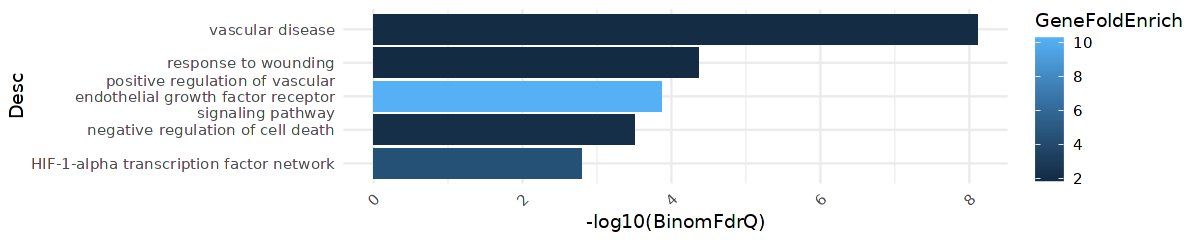

In [30]:
options(repr.plot.width=10, repr.plot.height=2)
ggplot(data = selected, aes(x = Desc, y = neg_log10_BinomFdrQ, fill = GeneFoldEnrich)) +
      geom_bar(stat = "identity") +
      theme_minimal() +
      labs(
           y = "-log10(BinomFdrQ)") +
      coord_flip() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_gradient(low = "#132B43", high = "#56B1F7", limits = c(1.87,10.3))

## C3

In [32]:
# Read in GREAT results
header = read.table('/home/jupyter/scATAC_analysis/edit/data/inhouse_wu_long_yu/allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))

great_results = read.table('/home/jupyter/scATAC_analysis/edit/data/inhouse_wu_long_yu/allcells/tumor/great/greatExportAll_c3.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
keep = c('GO Biological Process','Disease Ontology', 'MSigDB Pathway')
great_results$Ontology2 = great_results$Ontology
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 

In [33]:
# Subset to terms we want to plot for C3
terms= c('interferon-gamma-mediated signaling pathway','regulation of lymphocyte activation','positive regulation of apoptotic signaling pathway', 'nephritis', 'response to cytokine stimulus','cell activation')
selected = great_results %>% filter(Desc %in% terms)
selected$Desc <- str_wrap(selected$Desc, width = 40)
selected <- selected %>%
  mutate(neg_log10_BinomFdrQ = -log10(BinomFdrQ))

In [34]:
min(selected$GeneFoldEnrich)
max(selected$GeneFoldEnrich)

[1] 1.880505

[1] 5.234586

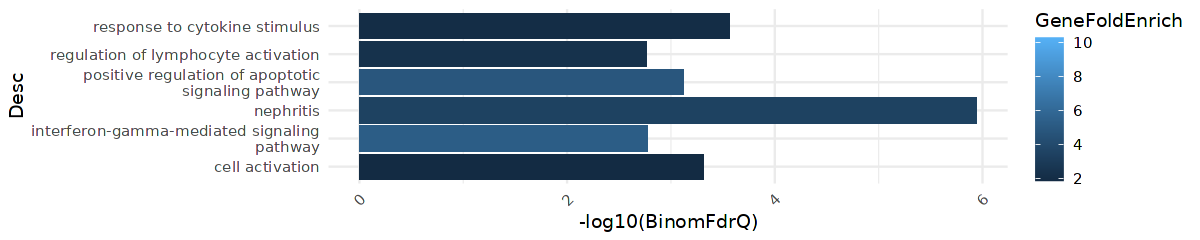

In [35]:
options(repr.plot.width=10, repr.plot.height=2)
ggplot(data = selected, aes(x = Desc, y = neg_log10_BinomFdrQ, fill = GeneFoldEnrich)) +
      geom_bar(stat = "identity") +
      theme_minimal() +
      labs(
           y = "-log10(BinomFdrQ)") +
      coord_flip() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_fill_gradient(low = "#132B43", high = "#56B1F7", limits = c(1.87,10.3))


# Figure 2F: Coverage plots of specific peaks contributing to GREAT pathway results

## C1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 28 rows containing missing values (`geom_segment()`)."


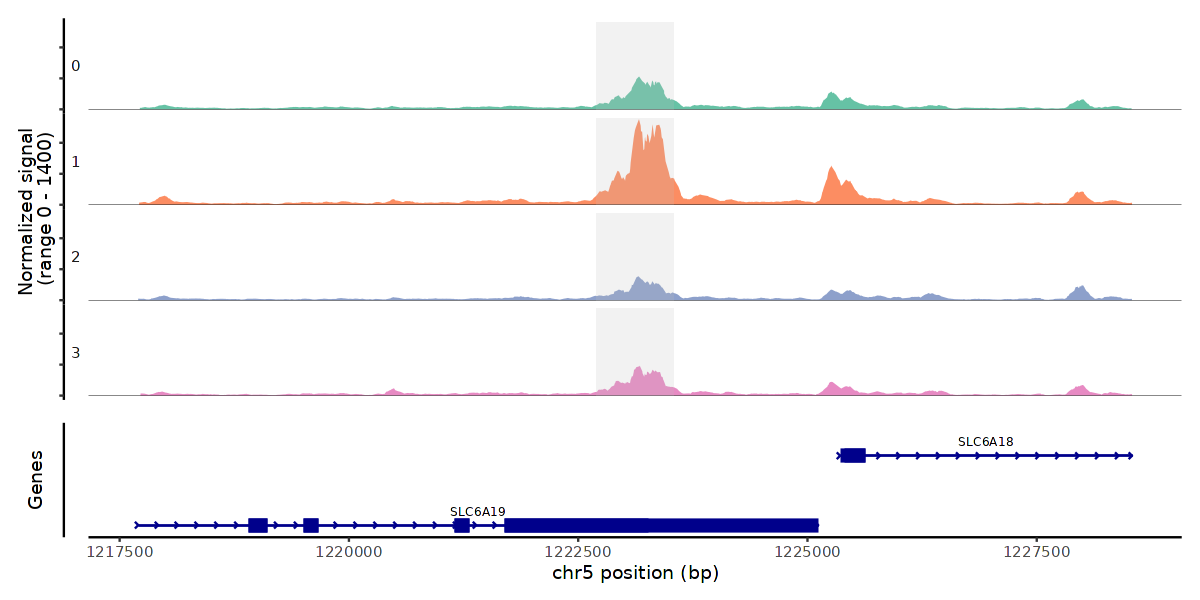

In [36]:
peak = 'chr5-1222702-1223539'
granges = Signac:::FindRegion(ccrcc,peak)

options(repr.plot.width=10, repr.plot.height=5)
CoveragePlot(ccrcc, region = granges, region.highlight = granges, extend.upstream = 5000, extend.downstream = 5000, peaks = FALSE) & scale_fill_manual(values = tumor_cols)

In [8]:
sigpeaks %>% filter((cluster == 1) & (gene == 'chr5-1222702-1223539'))

row.names            p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster
1 chr5-1222702-1223539 1.264527e-14 1.639349   0.171 0.053 5.925942e-09 1      
  gene                
1 chr5-1222702-1223539

## C2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 46 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."


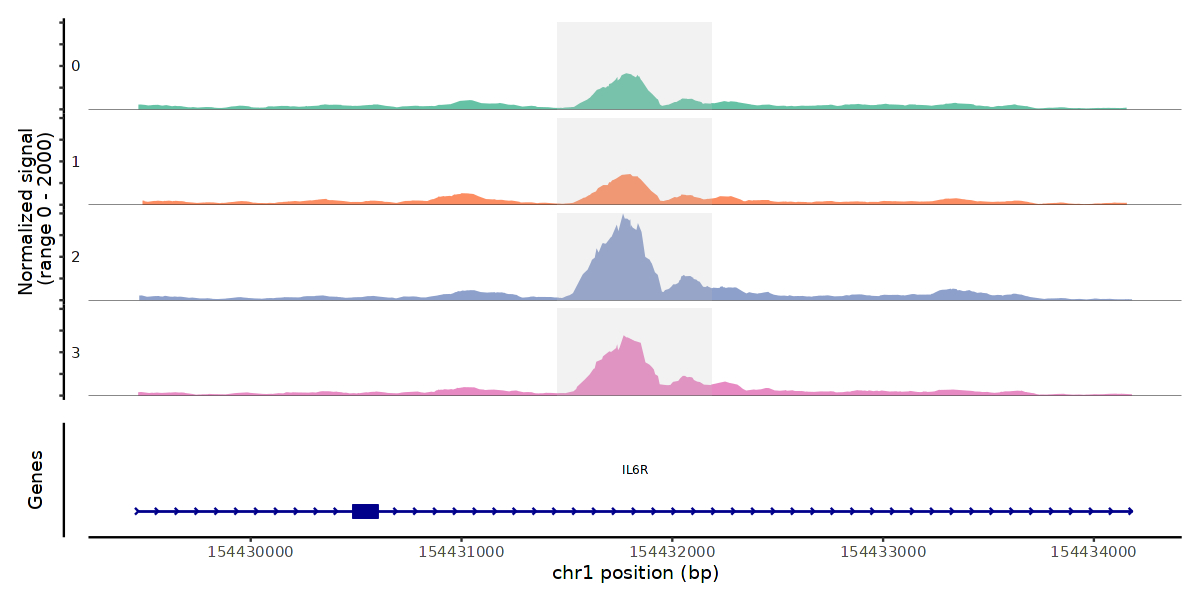

In [37]:
peak = 'chr1-154431466-154432181'
granges = Signac:::FindRegion(ccrcc,peak)

options(repr.plot.width=10, repr.plot.height=5)
CoveragePlot(ccrcc, region = granges, region.highlight = granges, extend.upstream = 2000, extend.downstream = 2000, peaks = FALSE) & scale_fill_manual(values = tumor_cols)

In [38]:
sigpeaks %>% filter((cluster == 2) & (gene == 'chr1-154431466-154432181'))

row.names                p_val        avg_log2FC pct.1 pct.2 p_val_adj   
1 chr1-154431466-154432181 6.516594e-10 1.124017   0.161 0.074 0.0003053865
  cluster gene                    
1 2       chr1-154431466-154432181

## C3

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 24 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."


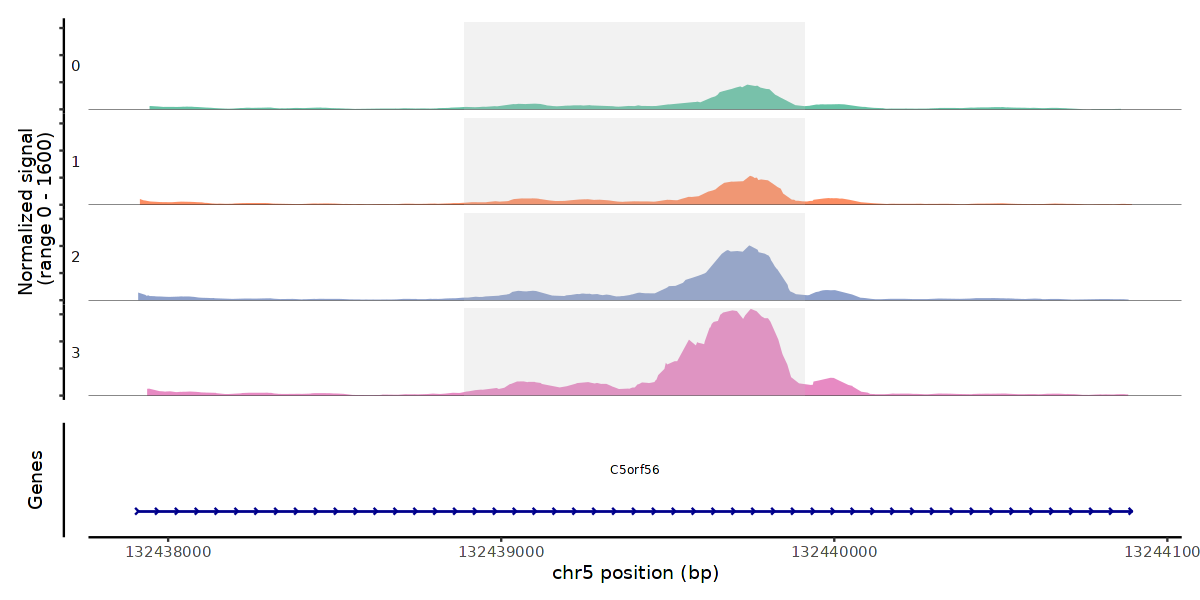

In [39]:
peak = 'chr5-132438910-132439894'
granges = Signac:::FindRegion(ccrcc,peak)

options(repr.plot.width=10, repr.plot.height=5)
CoveragePlot(ccrcc, region = granges, region.highlight = granges, extend.upstream = 1000, extend.downstream = 1000, peaks = FALSE) & scale_fill_manual(values = tumor_cols)

In [40]:
sigpeaks %>% filter((cluster == 3) & (gene == 'chr5-132438910-132439894'))

row.names                p_val        avg_log2FC pct.1 pct.2 p_val_adj 
1 chr5-132438910-132439894 5.099206e-08 1.63423    0.169 0.052 0.02389636
  cluster gene                    
1 3       chr5-132438910-132439894

# Figure 2G:

## Enriched TF motif binding sites per ccRCC peak sets

Motif enrichment results in Supp table 2, sheet D. 

In [43]:
source('../../snatac-rcc-manuscript-data/functions.r')

In [41]:
# Get enriched motif per peak set, c0 had no significant peaks

DefaultAssay(ccrcc) = 'ATAC'
results = list()
clusters = c(1,2,3)
for (cluster in clusters) {
    cluster_peaks = sigpeaks %>% filter(cluster == !!cluster)
    
    # Define a set of background peaks
    ## Find peaks that are open in a significant portion of cells
    percent_to_num_cells = ceiling(nrow(ccrcc@meta.data) * 0.1)
    open_peaks <- AccessiblePeaks(ccrcc, min.cells = percent_to_num_cells)

    ## Match the overall GC content in the peak set
    meta.feature <- GetAssayData(ccrcc, assay = "ATAC", slot = "meta.features")
    peaks_matched <- MatchRegionStats(
    meta.feature = meta.feature[open_peaks, ],
    query.feature = meta.feature[cluster_peaks$gene, ]
    )
    
    # Hypergeometric test
    enriched.motifs <- FindMotifs(
    object = ccrcc,
    features = cluster_peaks$gene,
        background = peaks_matched
    )
    
    # Combine
    enriched.motifs$cluster = cluster
    results[[cluster]] = enriched.motifs
}

enriched.motifs.all = dplyr::bind_rows(results)

Matching GC.percent distribution

Testing motif enrichment in 277 regions

Matching GC.percent distribution

Testing motif enrichment in 328 regions

Matching GC.percent distribution

Testing motif enrichment in 422 regions



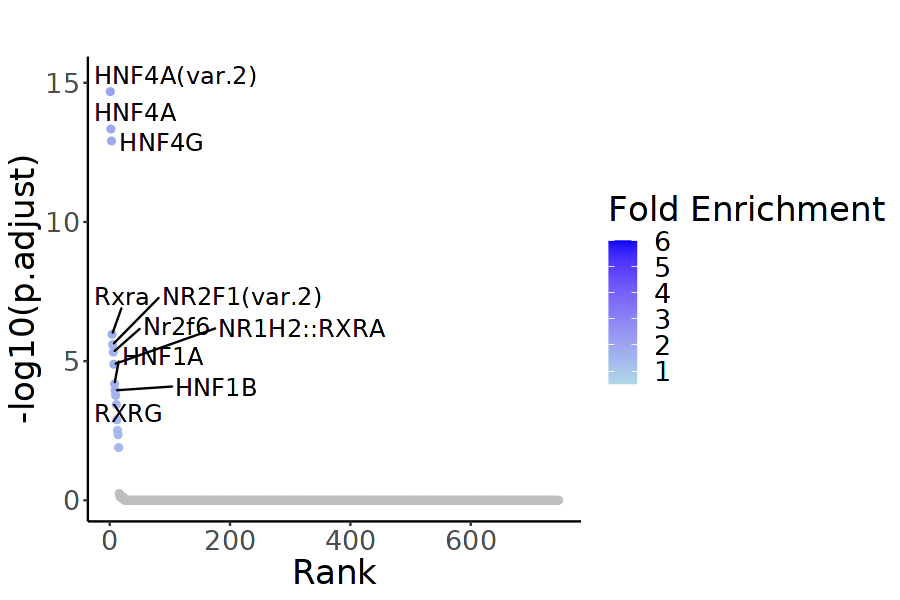

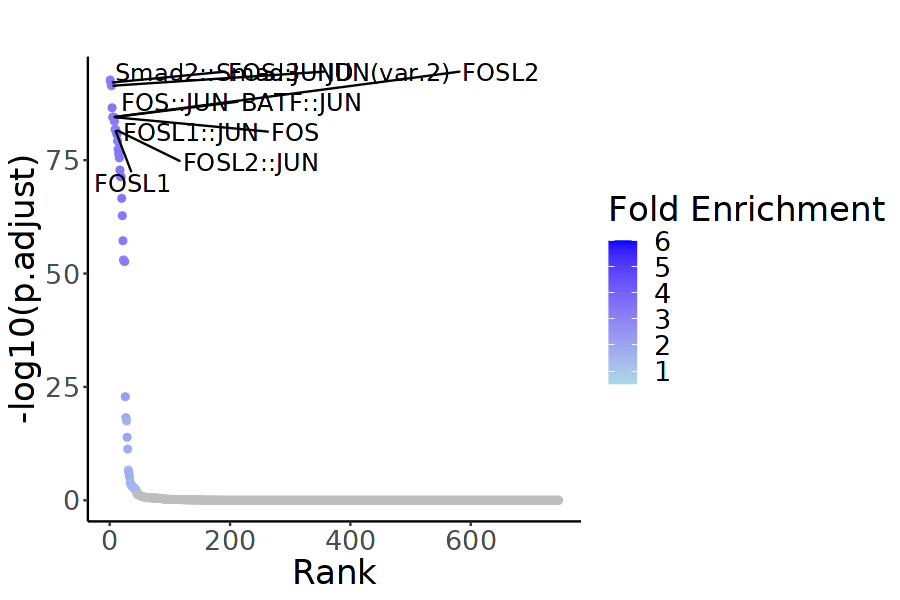

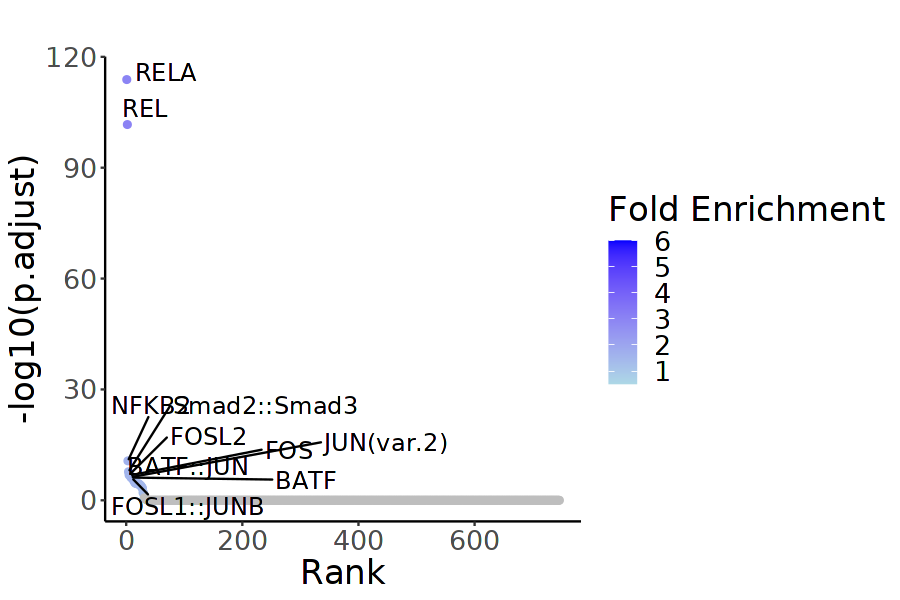

In [44]:
# Visualize top motifs per peak set
options(repr.plot.width=7.5, repr.plot.height=5)
create_motif_significance_plot(enriched.motifs.all %>% filter(cluster == 1), n_annotate = 10, color_gradient_limits = c(0.5,6) ) + ggtitle("")
create_motif_significance_plot(enriched.motifs.all %>% filter(cluster == 2), n_annotate = 10, color_gradient_limits = c(0.5,6) ) + ggtitle("")
create_motif_significance_plot(enriched.motifs.all %>% filter(cluster == 3), n_annotate = 10, color_gradient_limits = c(0.5,6) ) + ggtitle("")


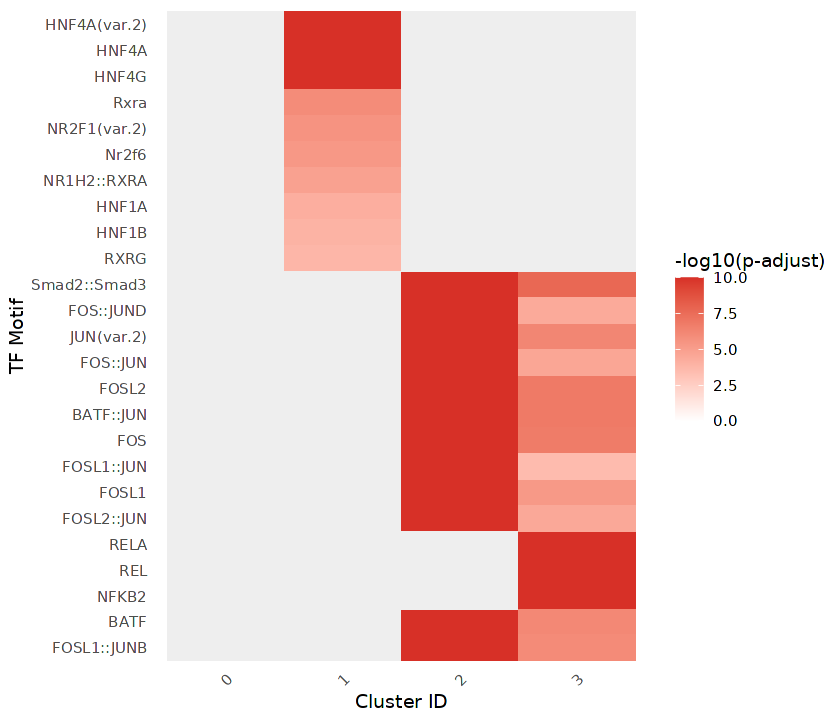

In [45]:
# Define a cap for the -log10(p.adjust) transformation
cap_value <- 10  # Adjust this cap value as needed

# Select top 10 TF motifs per cluster
motif_order = unique((enriched.motifs.all %>% group_by(cluster) %>%
    top_n(n = 10, wt = -p.adjust))$motif.name)

# Transform and cap p-values
df <- enriched.motifs.all %>% filter(motif.name %in% motif_order) %>%
  mutate(log_p_adjust = ifelse(p.adjust > 0.05, NA, -log10(p.adjust))) %>%
  mutate(log_p_adjust = ifelse(!is.na(log_p_adjust) & log_p_adjust > cap_value, cap_value, log_p_adjust)) %>%
  # Ensure factor levels are in the order you want
  mutate(motif.name = factor(motif.name, levels = rev(motif_order)),
         cluster = factor(cluster, levels = c(1,2,3)))

# Add Cluster 0 with all NA values, no results because no peaks
cluster_0 <- data.frame(motif.name = levels(df$motif.name), cluster = factor("0", levels = c("0", levels(df$cluster))), log_p_adjust = NA)
df <- dplyr::bind_rows(cluster_0, df)
df = df %>% mutate(motif.name = factor(motif.name, levels = rev(motif_order)),
         cluster = factor(cluster, levels = c(0,1,2,3)))

options(repr.plot.width=7, repr.plot.height=6)
# Create heatmap
ggplot(df, aes(x = cluster, y = motif.name, fill = log_p_adjust)) +
  geom_tile() +  # Use geom_tile for heatmap squares
  scale_fill_gradient(low = "white", high = "#d73027", na.value = "#eeeeee", limits = c(0, cap_value)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  labs(fill = "-log10(p-adjust)", x = "Cluster ID", y = "TF Motif")


## PWM for selected motifs

C1

Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>."


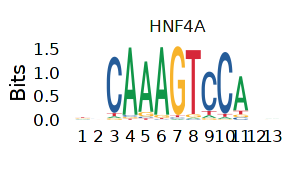

In [46]:
options(repr.plot.width=2.5, repr.plot.height=1.5)
MotifPlot(
  object = ccrcc,
  motifs =unique((df %>% filter(motif.name %in% c('HNF4A','FOS','RELA')))$motif)[-1][1]
)

C2

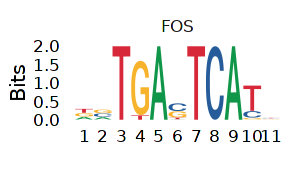

In [48]:
options(repr.plot.width=2.5, repr.plot.height=1.5)
MotifPlot(
  object = ccrcc,
  motifs =unique((df %>% filter(motif.name %in% c('HNF4A','FOS','RELA')))$motif)[-1][2]
)

C3

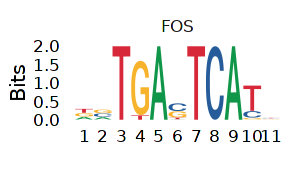

In [49]:
options(repr.plot.width=2.5, repr.plot.height=1.5)
MotifPlot(
  object = ccrcc,
  motifs =unique((df %>% filter(motif.name %in% c('HNF4A','FOS','RELA')))$motif)[-1][2]
)

# Figure 2H: TF footprinting plots for selected motifs

In [5]:
# gather the footprinting information for sets of motifs
ccrcc <- Footprint(
  object = ccrcc,
  motif.name = c("HNF4A", "RELA", "FOS"),
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in 

C1

Warning message:
"Removed 2052 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2052 rows containing missing values (`geom_label_repel()`)."


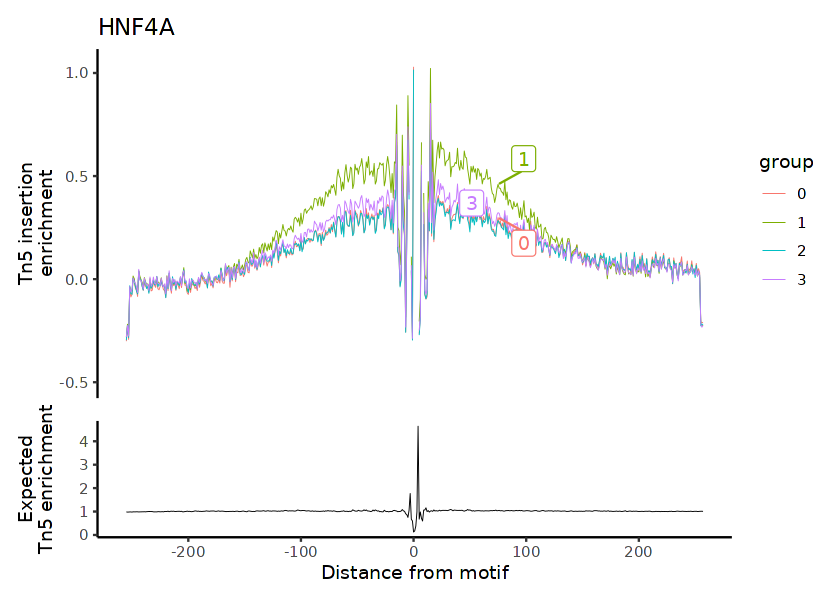

In [7]:
options(repr.plot.width=7, repr.plot.height=5)
PlotFootprint(ccrcc, features = 'HNF4A')

C2

Warning message:
"Removed 2044 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2044 rows containing missing values (`geom_label_repel()`)."


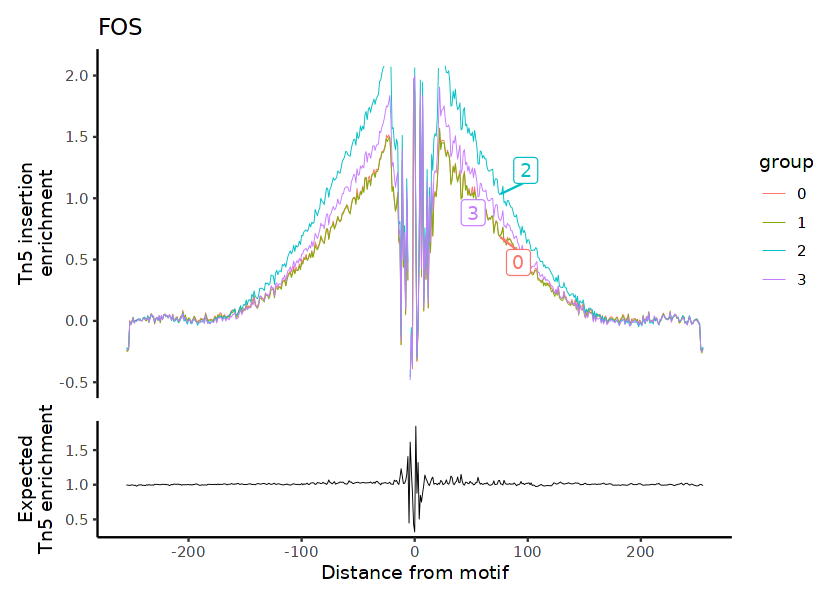

In [9]:
options(repr.plot.width=7, repr.plot.height=5)
PlotFootprint(ccrcc, features = 'FOS')

C3

Warning message:
"Removed 2040 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2040 rows containing missing values (`geom_label_repel()`)."


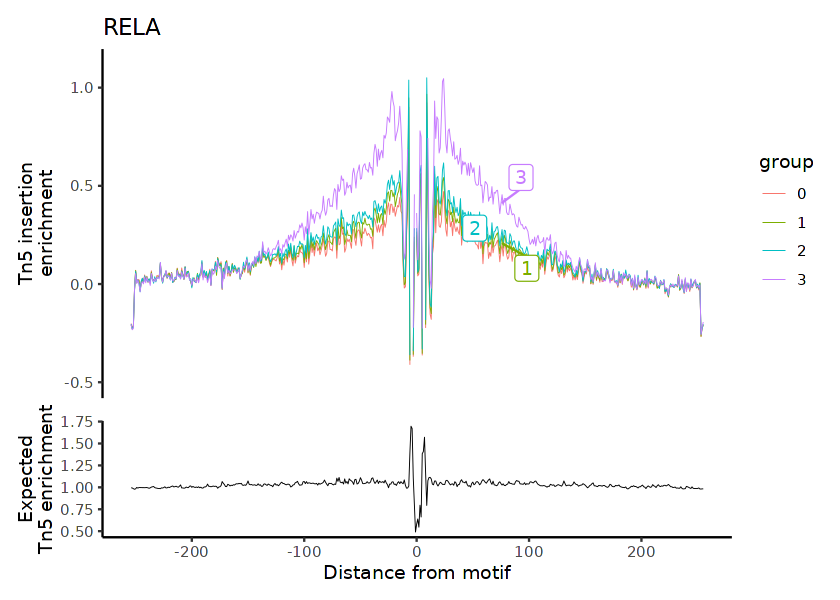

In [8]:
options(repr.plot.width=7, repr.plot.height=5)
PlotFootprint(ccrcc, features = 'RELA')